In [1]:
# Import necessary libraries
import os
import math
import glob
from PIL import Image
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# ============================================================
# Config
# ============================================================
class Config:
    image_size = 64
    channels = 3
    batch_size = 64
    num_epochs = 5
    lr = 2e-4
    num_timesteps = 1000
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data_dir = "/kaggle/input/bitmojis/bitmojis"
    num_workers = 0  # Set to 0 for Kaggle
    sample_every_epochs = 2
    ckpt_path = "ddpm_bitmoji_unet.pth"

cfg = Config()
print(f"Device: {cfg.device}")
print(f"CUDA Available: {torch.cuda.is_available()}")

Device: cuda
CUDA Available: True


In [2]:
# Dataset
# ============================================================

class BitmojiDataset(Dataset):
    def __init__(self, root_dir, image_size=64):
        self.root_dir = root_dir
        self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**", "*.png"), recursive=True))
        if len(self.image_paths) == 0:
            self.image_paths = sorted(glob.glob(os.path.join(root_dir, "**", "*.jpg"), recursive=True))

        print(f"Found {len(self.image_paths)} images")
        
        self.transform = T.Compose([
            T.Resize((image_size, image_size)),
            T.ToTensor(),
            T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("RGB")
        img = self.transform(img)
        return img

In [3]:
# Sinusoidal time embedding
# ============================================================

def sinusoidal_time_embedding(timesteps, dim):
    device = timesteps.device
    half_dim = dim // 2
    freqs = torch.exp(
        -math.log(10000) * torch.arange(0, half_dim, dtype=torch.float32, device=device) / half_dim
    )
    args = timesteps.float().unsqueeze(1) * freqs.unsqueeze(0)
    emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
    if dim % 2 == 1:
        emb = F.pad(emb, (0, 1))
    return emb

In [4]:
# Simple U-Net for 64x64 images
# ============================================================

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim=None):
        super().__init__()
        self.time_emb_dim = time_emb_dim
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)
        self.bn2 = nn.BatchNorm2d(out_ch)
        if time_emb_dim is not None:
            self.time_mlp = nn.Linear(time_emb_dim, out_ch)

    def forward(self, x, t_emb=None):
        x = self.conv1(x)
        x = self.bn1(x)
        if (t_emb is not None) and (self.time_emb_dim is not None):
            t_added = self.time_mlp(t_emb)[:, :, None, None]
            x = x + t_added
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        return x

class UNet(nn.Module):
    def __init__(self, in_ch=3, base_ch=64, time_emb_dim=256):
        super().__init__()
        self.time_emb_dim = time_emb_dim

        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim),
        )

        self.down1 = DoubleConv(in_ch, base_ch, time_emb_dim)
        self.down2 = DoubleConv(base_ch, base_ch * 2, time_emb_dim)
        self.down3 = DoubleConv(base_ch * 2, base_ch * 4, time_emb_dim)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(base_ch * 4, base_ch * 8, time_emb_dim)

        self.up3 = nn.ConvTranspose2d(base_ch * 8, base_ch * 4, 2, stride=2)
        self.dec3 = DoubleConv(base_ch * 8, base_ch * 4, time_emb_dim)

        self.up2 = nn.ConvTranspose2d(base_ch * 4, base_ch * 2, 2, stride=2)
        self.dec2 = DoubleConv(base_ch * 4, base_ch * 2, time_emb_dim)

        self.up1 = nn.ConvTranspose2d(base_ch * 2, base_ch, 2, stride=2)
        self.dec1 = DoubleConv(base_ch * 2, base_ch, time_emb_dim)

        self.final = nn.Conv2d(base_ch, in_ch, kernel_size=1)

    def forward(self, x, t):
        t_emb = sinusoidal_time_embedding(t, self.time_emb_dim)
        t_emb = self.time_mlp(t_emb)

        x1 = self.down1(x, t_emb)
        x2 = self.down2(self.pool(x1), t_emb)
        x3 = self.down3(self.pool(x2), t_emb)

        xb = self.bottleneck(self.pool(x3), t_emb)

        x = self.up3(xb)
        x = torch.cat([x, x3], dim=1)
        x = self.dec3(x, t_emb)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec2(x, t_emb)

        x = self.up1(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec1(x, t_emb)

        out = self.final(x)
        return out

In [5]:
# Diffusion utilities (beta schedule, forward process, sampling)
# ============================================================

class Diffusion:
    def __init__(self, num_timesteps=1000, device="cuda"):
        self.num_timesteps = num_timesteps
        self.device = device

        betas = torch.linspace(1e-4, 0.02, num_timesteps, dtype=torch.float32)
        self.betas = betas.to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def q_sample(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)
        alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x0 + torch.sqrt(1.0 - alpha_bar_t) * noise

    def p_sample_step(self, model, x_t, t):
        b = x_t.size(0)
        t_batch = torch.full((b,), t, device=x_t.device, dtype=torch.long)

        eps_theta = model(x_t, t_batch)

        beta_t = self.betas[t]
        alpha_t = self.alphas[t]
        alpha_bar_t = self.alpha_bars[t]
        alpha_bar_prev = self.alpha_bars[t - 1] if t > 0 else torch.tensor(1.0, device=self.device)

        beta_t = beta_t.view(1, 1, 1, 1)
        alpha_t = alpha_t.view(1, 1, 1, 1)
        alpha_bar_t = alpha_bar_t.view(1, 1, 1, 1)
        alpha_bar_prev = alpha_bar_prev.view(1, 1, 1, 1)

        x0_pred = (x_t - torch.sqrt(1.0 - alpha_bar_t) * eps_theta) / torch.sqrt(alpha_bar_t)

        coef1 = torch.sqrt(alpha_bar_prev) * beta_t / (1.0 - alpha_bar_t)
        coef2 = torch.sqrt(alpha_t) * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
        mean = coef1 * x0_pred + coef2 * x_t

        if t > 0:
            noise = torch.randn_like(x_t)
            var = beta_t * (1.0 - alpha_bar_prev) / (1.0 - alpha_bar_t)
            std = torch.sqrt(var)
            x_prev = mean + std * noise
        else:
            x_prev = mean
        return x_prev

    def p_sample_loop(self, model, shape):
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(shape, device=self.device)
            for t in tqdm(reversed(range(self.num_timesteps)), total=self.num_timesteps, desc="Sampling"):
                x_t = self.p_sample_step(model, x_t, t)
            return x_t

In [6]:
# Visualization function for adding noise and denoising
# ============================================================

def plot_noising_process(diffusion, x0, num_steps=8):
    """
    Plot forward diffusion process for a single image
    x0: (1, C, H, W)
    """
    diffusion_steps = torch.linspace(0, diffusion.num_timesteps - 1, num_steps, dtype=torch.long)
    x0_1 = x0[0:1]

    fig, axes = plt.subplots(1, num_steps, figsize=(16, 2))
    fig.suptitle('Forward Diffusion Process: Adding Noise Over Time', fontsize=14, fontweight='bold')

    for idx, t in enumerate(diffusion_steps):
        t_batch = torch.full((1,), int(t.item()), device=x0.device, dtype=torch.long)
        xt = diffusion.q_sample(x0_1, t_batch)
        
        # Denormalize
        img = (xt.cpu()[0] + 1.0) / 2.0
        img = torch.clamp(img, 0, 1)
        
        axes[idx].imshow(img.permute(1, 2, 0).numpy())
        axes[idx].set_title(f't={int(t.item())}', fontsize=10)
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_denoising_process(model, diffusion, num_steps=8):
    """
    Plot reverse diffusion process (denoising from pure noise)
    """
    model.eval()
    with torch.no_grad():
        x_t = torch.randn(1, cfg.channels, cfg.image_size, cfg.image_size, device=cfg.device)
        
        # Collect states at evenly spaced timesteps
        timestep_indices = np.linspace(diffusion.num_timesteps - 1, 0, num_steps, dtype=int)
        states = []
        
        for t in tqdm(reversed(range(diffusion.num_timesteps)), total=diffusion.num_timesteps, desc="Denoising"):
            x_t = diffusion.p_sample_step(model, x_t, t)
            
            # Save state at key timesteps
            if t in timestep_indices:
                states.append((t, x_t.clone()))
        
        # Sort by timestep (descending) for visualization
        states.sort(key=lambda x: x[0], reverse=True)
        
        # Plot
        fig, axes = plt.subplots(1, num_steps, figsize=(16, 2))
        fig.suptitle('Reverse Diffusion Process: Denoising Over Time', fontsize=14, fontweight='bold')
        
        for idx, (t, x_sample) in enumerate(states):
            img = (x_sample.cpu()[0] + 1.0) / 2.0
            img = torch.clamp(img, 0, 1)
            
            axes[idx].imshow(img.permute(1, 2, 0).numpy())
            axes[idx].set_title(f't={t}', fontsize=10)
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

In [7]:
# Visualization function for the loss curve and evaluzation metrics
def plot_loss_curve(losses):
    """Plot training loss over epochs"""
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, len(losses) + 1), losses, marker='o', linewidth=2, markersize=8, color='#3b82f6')
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
    ax.set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(1, len(losses) + 1))
    
    plt.tight_layout()
    plt.show()

def plot_evaluation_metrics(model, diffusion, dataloader, num_batches=5):
    """
    Calculate and plot evaluation metrics
    - MSE of noise prediction
    - SNR (Signal-to-Noise Ratio)
    """
    model.eval()
    mse_losses = []
    snr_values = []
    
    with torch.no_grad():
        for batch_idx, x0 in enumerate(dataloader):
            if batch_idx >= num_batches:
                break
            
            x0 = x0.to(cfg.device)
            b = x0.size(0)
            
            # Random timesteps
            t = torch.randint(0, cfg.num_timesteps, (b,), device=cfg.device).long()
            
            # Add noise
            noise = torch.randn_like(x0)
            x_t = diffusion.q_sample(x0, t, noise=noise)
            
            # Predict noise
            noise_pred = model(x_t, t)
            
            # MSE loss
            mse = F.mse_loss(noise_pred, noise).item()
            mse_losses.append(mse)
            
            # SNR calculation
            signal_power = torch.mean(noise ** 2).item()
            noise_power = torch.mean((noise_pred - noise) ** 2).item()
            snr = signal_power / (noise_power + 1e-8)
            snr_values.append(snr)
    
    avg_mse = np.mean(mse_losses)
    avg_snr = np.mean(snr_values)
    
    # Plot evaluation metrics
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # MSE histogram
    axes[0].hist(mse_losses, bins=20, color='#3b82f6', alpha=0.7, edgecolor='black')
    axes[0].axvline(avg_mse, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_mse:.4f}')
    axes[0].set_xlabel('MSE Loss', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[0].set_title('Noise Prediction MSE Distribution', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # SNR histogram
    axes[1].hist(snr_values, bins=20, color='#10b981', alpha=0.7, edgecolor='black')
    axes[1].axvline(avg_snr, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_snr:.4f}')
    axes[1].set_xlabel('SNR (dB)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[1].set_title('Signal-to-Noise Ratio Distribution', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nEVALUATION METRICS:")
    print(f"Average MSE Loss: {avg_mse:.6f}")
    print(f"Average SNR: {avg_snr:.6f}")

In [8]:
# Training loop
# ============================================================

def train():
    dataset = BitmojiDataset(cfg.data_dir, image_size=cfg.image_size)
    dataloader = DataLoader(
        dataset,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )

    model = UNet(in_ch=cfg.channels, base_ch=64, time_emb_dim=256).to(cfg.device)
    diffusion = Diffusion(num_timesteps=cfg.num_timesteps, device=cfg.device)
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    epoch_losses = []
    global_step = 0
    
    for epoch in range(cfg.num_epochs):
        model.train()
        epoch_loss = 0.0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{cfg.num_epochs}")
        
        for x0 in pbar:
            x0 = x0.to(cfg.device)

            b = x0.size(0)
            t = torch.randint(0, cfg.num_timesteps, (b,), device=cfg.device).long()

            noise = torch.randn_like(x0)
            x_t = diffusion.q_sample(x0, t, noise=noise)

            noise_pred = model(x_t, t)

            loss = F.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            global_step += 1
            epoch_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        avg_epoch_loss = epoch_loss / len(dataloader)
        epoch_losses.append(avg_epoch_loss)
        
        print(f"\nEpoch {epoch+1}/{cfg.num_epochs} - Average Loss: {avg_epoch_loss:.6f}")
        
        torch.save(model.state_dict(), cfg.ckpt_path)

        # Visualize after every few epochs
        if (epoch + 1) % cfg.sample_every_epochs == 0:
            with torch.no_grad():
                print(f"\n Generating visualizations for Epoch {epoch+1}...")
                
                # Get sample from dataset
                example_batch = next(iter(dataloader)).to(cfg.device)
                
                # Plot forward process
                print("Plotting forward diffusion process...")
                plot_noising_process(diffusion, example_batch)
                
                # Plot reverse process
                print("Plotting reverse diffusion process...")
                plot_denoising_process(model, diffusion, num_steps=8)
    
    # Plot final loss curve
    print("\nPlotting loss curve...")
    plot_loss_curve(epoch_losses)
    
    # Plot evaluation metrics
    print("\nCalculating evaluation metrics...")
    plot_evaluation_metrics(model, diffusion, dataloader, num_batches=10)
    
    return model, diffusion, epoch_losses

DIFFUSION MODEL TRAINING:
Device: cuda
Image Size: 64x64
Batch Size: 64
Epochs: 5
Learning Rate: 0.0002
Found 130227 images


Epoch 1/5: 100%|██████████| 2035/2035 [19:26<00:00,  1.74it/s, loss=0.00835]



Epoch 1/5 - Average Loss: 0.037681


Epoch 2/5: 100%|██████████| 2035/2035 [07:23<00:00,  4.58it/s, loss=0.00891]



Epoch 2/5 - Average Loss: 0.014714

📊 Generating visualizations for Epoch 2...
Plotting forward diffusion process...


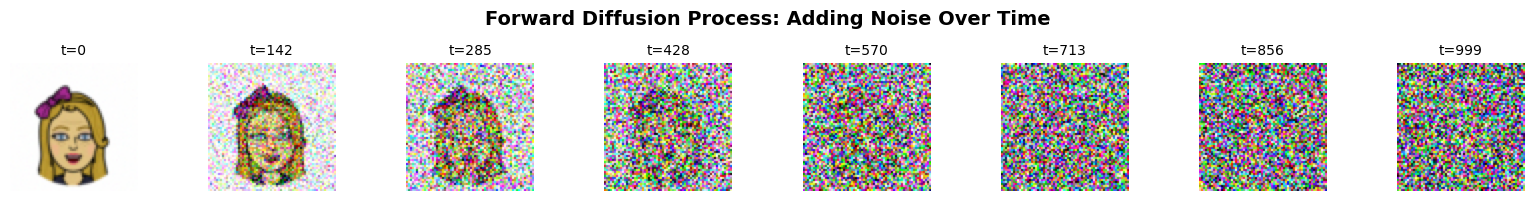

Plotting reverse diffusion process...


Denoising: 100%|██████████| 1000/1000 [00:03<00:00, 304.36it/s]


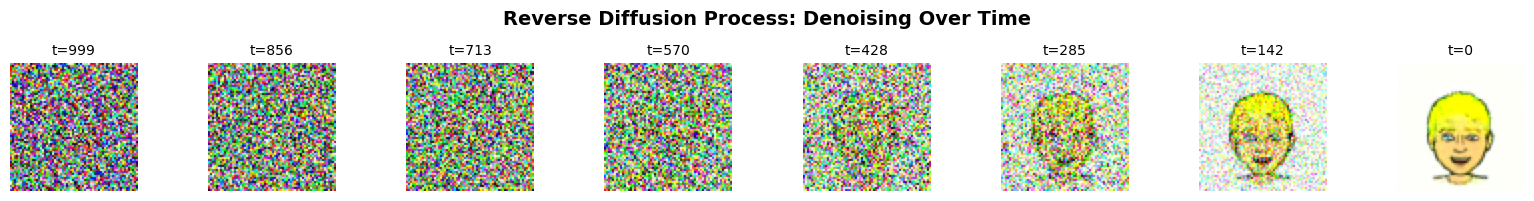

Epoch 3/5: 100%|██████████| 2035/2035 [06:50<00:00,  4.95it/s, loss=0.0119] 



Epoch 3/5 - Average Loss: 0.011957


Epoch 4/5: 100%|██████████| 2035/2035 [06:48<00:00,  4.98it/s, loss=0.00679]



Epoch 4/5 - Average Loss: 0.010292

📊 Generating visualizations for Epoch 4...
Plotting forward diffusion process...


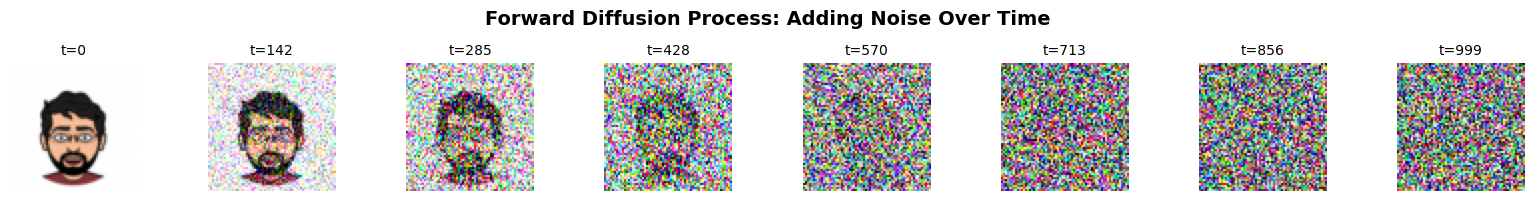

Plotting reverse diffusion process...


Denoising: 100%|██████████| 1000/1000 [00:03<00:00, 305.58it/s]


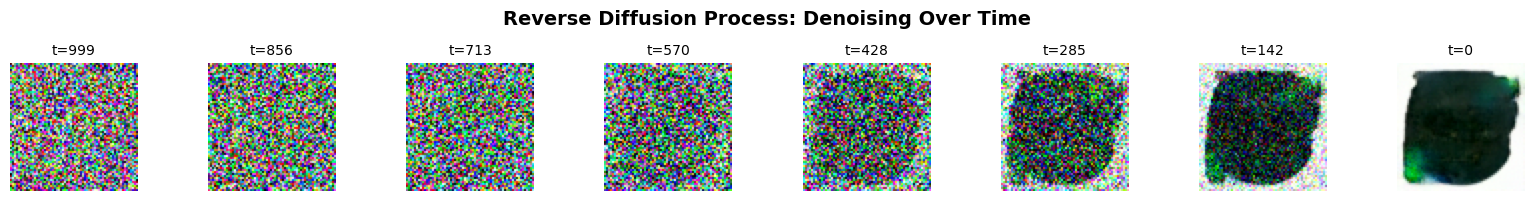

Epoch 5/5: 100%|██████████| 2035/2035 [06:51<00:00,  4.95it/s, loss=0.0105] 



Epoch 5/5 - Average Loss: 0.009531

Plotting loss curve...


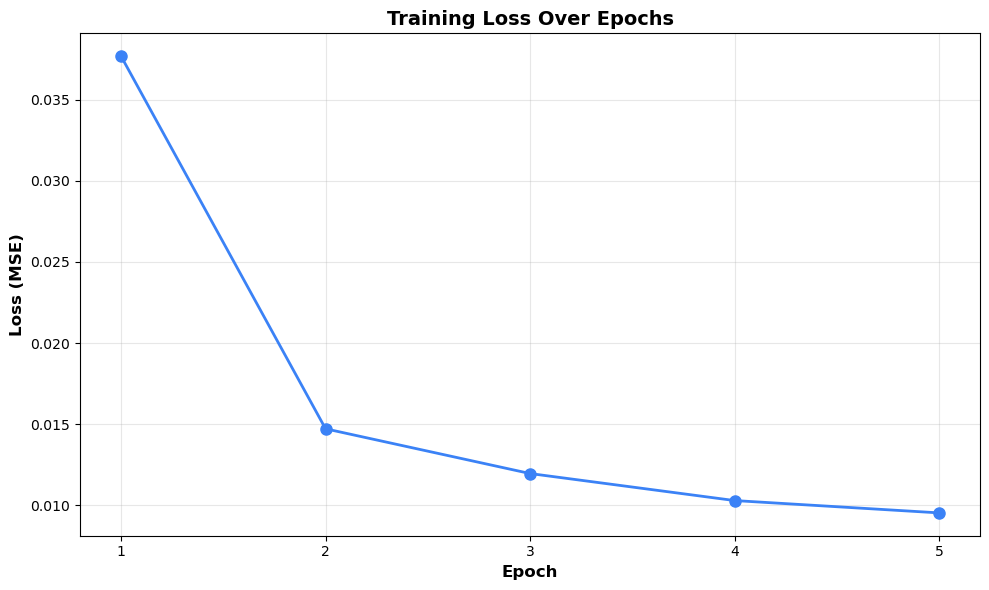


Calculating evaluation metrics...


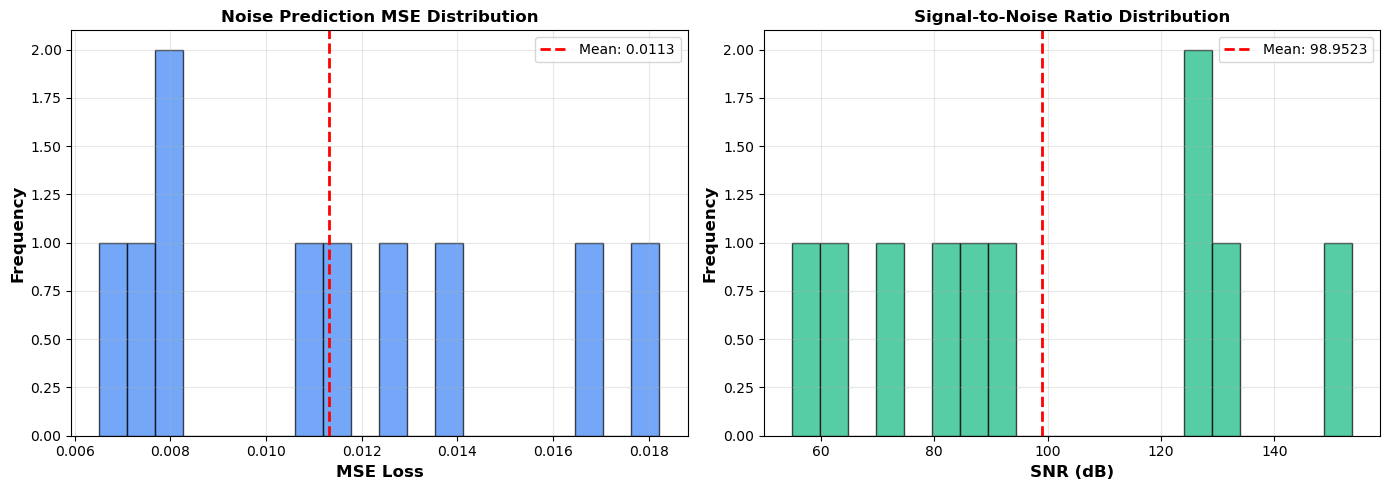


EVALUATION METRICS:
Average MSE Loss: 0.011311
Average SNR: 98.952303


In [9]:
# Main Execution
# ============================================================

if __name__ == "__main__":
    print("DIFFUSION MODEL TRAINING:")
    print(f"Device: {cfg.device}")
    print(f"Image Size: {cfg.image_size}x{cfg.image_size}")
    print(f"Batch Size: {cfg.batch_size}")
    print(f"Epochs: {cfg.num_epochs}")
    print(f"Learning Rate: {cfg.lr}")
    
    model, diffusion, losses = train()